# Projet Deep Learning M2TIDE 2021-2022
**Safa Hamdan-Laurène David-Allan Pendant**


Objectif :
Classifier des photos d'actrices (Natalie Portman, Keaira Knightley, Autres actrices)

### installation de mtcnn pour la détection faciale

In [1]:
!pip install mtcnn

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import cv2 # package d'OpenCV : traitement d'images
from mtcnn.mtcnn import MTCNN # CNN détecteur de visage voir dlib.cnn
import pandas as pd
import numpy as np
from PIL import Image # package Pillow : chargement d'images
import matplotlib.pyplot as plt
import matplotlib

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

## Train set construction

### Sources path

In [5]:
# Définition des chemins d'accès vers les fichiers Train
keira_train_source_path = '/kaggle/input/trainset/train/keira'
natalie_train_source_path = '/kaggle/input/trainset/train/nathalie'
others_train_source_path = '/kaggle/input/trainset/train/others'

In [6]:
train_path_list  = []
label_train_list = []
# création d'une liste comprennant le nom de toutes les images train de keira
keira_train_path_list = os.listdir(keira_train_source_path)
for file_name in keira_train_path_list:
    file_path = keira_train_source_path + "/" + file_name
    train_path_list.append(file_path)
    label_train_list.append(0) # 0 pour Keira
    
# création d'une liste comprennant le nom de toutes les images train de natalie
natalie_train_path_list = os.listdir(natalie_train_source_path)
for file_name in natalie_train_path_list:
    file_path = natalie_train_source_path + "/" + file_name
    train_path_list.append(file_path)
    label_train_list.append(1) # 1 pour Natalie
    
# autres
others_train_path_list = os.listdir(others_train_source_path)
for file_name in others_train_path_list:
    file_path = others_train_source_path + "/" + file_name
    train_path_list.append(file_path)
    label_train_list.append(2) # 2 pour les autres



In [7]:
print(len(train_path_list))
train_path_list[:10]

429


['/kaggle/input/trainset/train/keira/Capture dcran 2021-04-07  14.49.39.png',
 '/kaggle/input/trainset/train/keira/Capture dcran 2021-04-07  14.53.25.png',
 '/kaggle/input/trainset/train/keira/Capture dcran 2021-04-07  14.51.51.png',
 '/kaggle/input/trainset/train/keira/Capture dcran 2021-04-07  14.57.27.png',
 '/kaggle/input/trainset/train/keira/Capture dcran 2021-04-07  14.55.39.png',
 '/kaggle/input/trainset/train/keira/Capture dcran 2021-04-07  14.47.32.png',
 '/kaggle/input/trainset/train/keira/Capture dcran 2021-04-07  14.45.51.png',
 '/kaggle/input/trainset/train/keira/Capture dcran 2021-04-07  14.47.21.png',
 '/kaggle/input/trainset/train/keira/Capture dcran 2021-04-07  14.57.04.png',
 '/kaggle/input/trainset/train/keira/Capture dcran 2021-04-07  14.54.09.png']

### Chargement des images

In [8]:
size = 224

In [9]:
def load_img(file_path, resize=False, size=224):
    
    # Load image
    img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)[:,:,:3]
    
    if resize == True:
        return(cv2.resize(img, (size, size)))

    # Return image
    return img

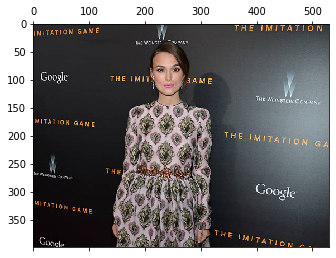

In [10]:
plt.matshow(load_img(train_path_list[0]))

In [11]:
def face_img(img_array, size = 224):
    """Revoie les coordonnées du visage présent sur l'image.
        Si plusieurs visages sont présents : renvoie l'image originelle
        
        *Args :
        img_array : numpy array
    """
    detector = MTCNN()
    faces = detector.detect_faces(img_array)
    if len(faces) == 1:
        x1, y1, width, height = faces[0]['box']
        x2, y2 = x1 + width, y1 + height
        img_face = img_array[y1:y2, x1:x2]
        img_face_resized = cv2.resize(img_face, (size,size))
        return(img_face_resized)
    
    else:
        img_resized = cv2.resize(img_array, (size,size))
        return(img_resized)

2022-07-31 13:17:51.809368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:17:51.819586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:17:51.820580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:17:51.822771: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

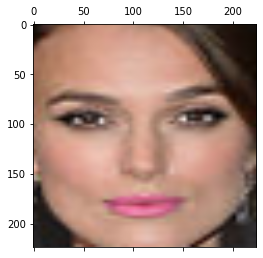

In [12]:
plt.matshow(face_img(load_img(train_path_list[0])))

In [13]:
train_set = pd.DataFrame()
x = []
file_name = []
for file_path in train_path_list:
    x.append(load_img(file_path, resize=True))
    file_name.append(file_path.split('/')[-1])

train_set["X"] = x
train_set["y"] = label_train_list.copy()
train_set["filename"] = file_name

train_set = train_set.sample(frac=1).reset_index(drop=True)

In [14]:
train_face_set = pd.DataFrame()
x = []
file_name = []
for file_path in train_path_list:
    x.append(face_img(load_img(file_path)))
    file_name.append(file_path.split('/')[-1])

train_face_set["X"] = x
train_face_set["y"] = label_train_list.copy()
train_face_set["filename"] = file_name

In [15]:
train_face_set = train_face_set.sample(frac=1).reset_index(drop=True)
X_train = np.asarray(train_set.X.to_list())/255.
X_train_face = np.asarray(train_face_set.X.to_list())/255.
y_train = train_set.y.to_list()
y_train_face = train_face_set.y

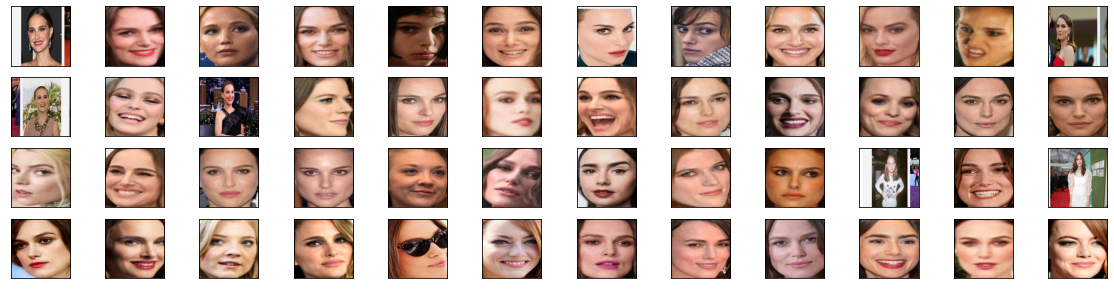

In [16]:
fig = plt.figure(figsize=(20,5))
for i in range(48):
    ax = fig.add_subplot(4,12,i+1, xticks=[],yticks=[])
    ax.imshow(np.squeeze(X_train_face[i]))

## Validation set construction

In [17]:
keira_valid_source_path = '/kaggle/input/valset/val/keira'
natalie_valid_source_path = '/kaggle/input/valset/val/nathalie'
others_valid_source_path = '/kaggle/input/valset/val/others'

In [18]:
valid_path_list  = []
label_valid_list = []
# création d'une liste comprennant le nom de toutes les images validations de keira
keira_valid_path_list = os.listdir(keira_valid_source_path)
for file_name in keira_valid_path_list:
    file_path = keira_valid_source_path + "/" + file_name
    valid_path_list.append(file_path)
    label_valid_list.append(0) # 0 pour Keira
    
# création d'une liste comprennant le nom de toutes les images validations de natalie
natalie_valid_path_list = os.listdir(natalie_valid_source_path)
for file_name in natalie_valid_path_list:
    file_path = natalie_valid_source_path + "/" + file_name
    valid_path_list.append(file_path)
    label_valid_list.append(1) # 1 pour Natalie
    
# autres
others_valid_path_list = os.listdir(others_valid_source_path)
for file_name in others_valid_path_list:
    file_path = others_valid_source_path + "/" + file_name
    valid_path_list.append(file_path)
    label_valid_list.append(2) # 2 pour les autres



In [19]:
valid_set = pd.DataFrame()
x = []
file_name = []
for file_path in valid_path_list:
    x.append(load_img(file_path, resize=True))
    file_name.append(file_path.split('/')[-1])

valid_set["X"] = x
valid_set["y"] = label_valid_list.copy()
valid_set["filename"] = file_name

valid_set = valid_set.sample(frac=1).reset_index(drop=True)

In [20]:
valid_face_set = pd.DataFrame()
x = []
file_name = []
for file_path in valid_path_list:
    x.append(face_img(load_img(file_path)))
    file_name.append(file_path.split('/')[-1])

valid_face_set["X"] = x
valid_face_set["y"] = label_valid_list.copy()
valid_face_set["filename"] = file_name

In [21]:
valid_face_set = valid_face_set.sample(frac=1).reset_index(drop=True)
X_valid = np.asarray(valid_set.X.to_list())/255.
X_valid_face = np.asarray(valid_face_set.X.to_list())/255.
y_valid = valid_set.y.to_list()
y_valid_face = valid_face_set.y

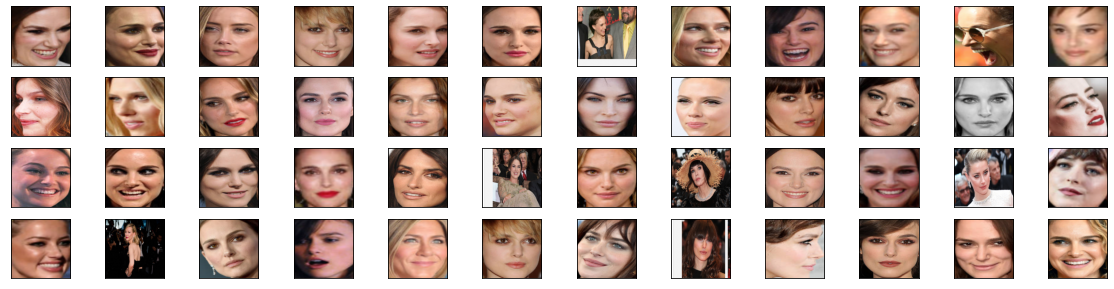

In [22]:
fig = plt.figure(figsize=(20,5))
for i in range(48):
    ax = fig.add_subplot(4,12,i+1, xticks=[],yticks=[])
    ax.imshow(np.squeeze(X_valid_face[i]))

## Test set construction

In [23]:
keira_test_source_path = '/kaggle/input/testset/test/keira'
natalie_test_source_path = '/kaggle/input/testset/test/nathalie'
others_test_source_path = '/kaggle/input/testset/test/others'

In [24]:
test_path_list  = []
label_test_list = []
# création d'une liste comprennant le nom de toutes les images test de keira
keira_test_path_list = os.listdir(keira_test_source_path)
for file_name in keira_test_path_list:
    file_path = keira_test_source_path + "/" + file_name
    test_path_list.append(file_path)
    label_test_list.append(0) # 0 pour Keira
    
# création d'une liste comprennant le nom de toutes les images test de natalie
natalie_test_path_list = os.listdir(natalie_test_source_path)
for file_name in natalie_test_path_list:
    file_path = natalie_test_source_path + "/" + file_name
    test_path_list.append(file_path)
    label_test_list.append(1) # 1 pour Natalie
    
# autres
others_test_path_list = os.listdir(others_test_source_path)
for file_name in others_test_path_list:
    file_path = others_test_source_path + "/" + file_name
    test_path_list.append(file_path)
    label_test_list.append(2) # 2 pour les autres



In [25]:
test_set = pd.DataFrame()
x = []
file_name = []
for file_path in test_path_list:
    x.append(load_img(file_path, resize=True))
    file_name.append(file_path.split('/')[-1])

test_set["X"] = x
test_set["y"] = label_test_list.copy()
test_set["filename"] = file_name

test_set = test_set.sample(frac=1).reset_index(drop=True)

In [26]:
test_face_set = pd.DataFrame()
x = []
file_name = []
for file_path in test_path_list:
    x.append(face_img(load_img(file_path)))
    file_name.append(file_path.split('/')[-1])

test_face_set["X"] = x
test_face_set["y"] = label_test_list.copy()
test_face_set["filename"] = file_name

In [27]:
test_face_set = test_face_set.sample(frac=1).reset_index(drop=True)
X_test = np.asarray(test_set.X.to_list())/255.
X_test_face = np.asarray(test_face_set.X.to_list())/255.
y_test = test_set.y
y_test_face = test_face_set.y

# Construction manuelle d'un Modèle

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [29]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [30]:
datagen = ImageDataGenerator(
)

# datagen.fit(X_train_face)

In [31]:
model = keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

## Choix d'un optimizer et compilation du modèle

In [32]:
# opt = keras.optimizers.Adam(
#     learning_rate=0.9
# )

# opt = keras.optimizers.RMSprop(
#     learning_rate=0.01
# )
# opt = keras.optimizers.Adagrad(
#     learning_rate=0.01
# )

# opt = keras.optimizers.Adamax(
#     learning_rate=0.001
# )

opt = keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9
)



model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

def drop_lr_manu(epoch, lr):
  if epoch == 0:
    return lr
  if (epoch % 70) == 0:
    return lr * 0.32
  else:
    return lr

sc_manu = LearningRateScheduler(drop_lr_manu)

## Entraînement du modèle manuel

In [33]:
from gc import callbacks
model.fit(datagen.flow(X_train_face, y_train_face, batch_size=16), epochs=250, validation_data=datagen.flow(X_valid_face, y_valid_face, batch_size=16), callbacks=[sc_manu])

Epoch 1/250
27/27 [==============================] - 8s 175ms/step - loss: 3.1558 - accuracy: 0.3683 - val_loss: 95288584.0000 - val_accuracy: 0.3163
Epoch 2/250
27/27 [==============================] - 3s 125ms/step - loss: 3.8755 - accuracy: 0.4056 - val_loss: 153055.9531 - val_accuracy: 0.2755
Epoch 3/250
27/27 [==============================] - 3s 128ms/step - loss: 3.6189 - accuracy: 0.4848 - val_loss: 8224.8242 - val_accuracy: 0.3163
Epoch 4/250
27/27 [==============================] - 3s 125ms/step - loss: 3.6062 - accuracy: 0.4569 - val_loss: 16180.3076 - val_accuracy: 0.3776
Epoch 5/250
27/27 [==============================] - 3s 128ms/step - loss: 3.8360 - accuracy: 0.4872 - val_loss: 3873.3438 - val_accuracy: 0.3163
Epoch 6/250
27/27 [==============================] - 3s 126ms/step - loss: 2.6119 - accuracy: 0.5058 - val_loss: 1131.7971 - val_accuracy: 0.3265
Epoch 7/250
27/27 [==============================] - 3s 124ms/step - loss: 2.3530 - accuracy: 0.5734 - val_loss: 565.

# Evaluation du modèle manuel

In [34]:
datagen_test = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False)
# datagen_test.fit(x_test)

In [35]:
score = model.evaluate(datagen_test.flow(X_test_face, y_test_face, batch_size=1, shuffle=False))

70/70 [==============================] - 1s 11ms/step - loss: 4.8198 - accuracy: 0.6286


In [36]:
print(f"Test accuracy : {score[1]*100:.2f}%")

Test accuracy : 62.86%


#  Transfert learning RESNET152V2

https://keras.io/api/applications/resnet/#resnet152v2-function

In [37]:
# RESNET152V2
model = keras.applications.ResNet152V2(include_top=False,
                                       weights='imagenet',
                                       input_shape = (224,224,3)
                                      )

for layer in model.layers:
    layer.trainable = False

# for (i, layer) in enumerate(model.layers):
#     print(str(i) + " " + layer.__class__.__name__, layer.trainable)

In [38]:
model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1795')>

## Ajout de couches supplémentaires

In [39]:
def addlayer(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = layers.GlobalAveragePooling2D()(top_model)
    top_model = layers.Dense(1024, activation="relu")(top_model)
    top_model = layers.BatchNormalization()(top_model)
    top_model = layers.Dense(1024, activation="relu")(top_model)
    top_model = layers.Dropout(0.5)(top_model)
    top_model = layers.Dense(num_classes, activation='softmax')(top_model)
    return top_model

In [40]:
num_classes = 3

FC_Head = addlayer(model, num_classes)
modelnew = keras.models.Model(model.input, outputs=FC_Head)

## Pré-entraînement des couches supplémentaires

In [41]:
def drop_lr_train(epoch, lr):
  if epoch == 0:
    return lr
  if (epoch % 75) == 0:
    return lr * 0.32
  else:
    return lr

sc_train = LearningRateScheduler(drop_lr_train)

In [42]:
opt = keras.optimizers.RMSprop(
)
#opt = keras.optimizers.SGD(
#    learning_rate=0.0001,
#    momentum=0.9
#)

modelnew.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [43]:
datagen = ImageDataGenerator(
)

# datagen.fit(X_train_face)

In [44]:
from gc import callbacks
modelnew.fit(datagen.flow(X_train_face, y_train_face, batch_size=32), epochs=30, validation_data=(X_valid_face, y_valid_face), callbacks=[sc_train])

Epoch 1/30
14/14 [==============================] - 17s 460ms/step - loss: 2.3146 - accuracy: 0.4918 - val_loss: 3.8831 - val_accuracy: 0.3163
Epoch 2/30
14/14 [==============================] - 2s 172ms/step - loss: 1.0476 - accuracy: 0.7086 - val_loss: 2.0234 - val_accuracy: 0.3265
Epoch 3/30
14/14 [==============================] - 2s 167ms/step - loss: 0.6951 - accuracy: 0.8112 - val_loss: 2.1416 - val_accuracy: 0.4694
Epoch 4/30
14/14 [==============================] - 2s 168ms/step - loss: 0.5357 - accuracy: 0.8112 - val_loss: 1.6682 - val_accuracy: 0.4694
Epoch 5/30
14/14 [==============================] - 2s 167ms/step - loss: 0.3481 - accuracy: 0.8974 - val_loss: 1.6048 - val_accuracy: 0.4796
Epoch 6/30
14/14 [==============================] - 3s 190ms/step - loss: 0.3187 - accuracy: 0.9114 - val_loss: 2.9677 - val_accuracy: 0.4184
Epoch 7/30
14/14 [==============================] - 2s 170ms/step - loss: 0.2252 - accuracy: 0.9277 - val_loss: 1.8817 - val_accuracy: 0.4490
Epoch

## Entraînement du modèle

**Nous choisissons de rendre entraînables les couches d'indice supérieur à 273.**

In [45]:
for layer in modelnew.layers[:273]:
    layer.trainable = False
for layer in modelnew.layers[273:]:
    layer.trainable = True

In [46]:
# for (i, layer) in enumerate(modelnew.layers):
#     print(str(i) + " " + layer.__class__.__name__, layer.trainable)

In [47]:
def drop_lr(epoch, lr):
  if epoch == 0:
    return lr
  if (epoch % 60) == 0:
    return lr * 0.32
  else:
    return lr

sc = LearningRateScheduler(drop_lr)

In [48]:
#opt = keras.optimizers.RMSprop(
#    learning_rate=0.01
#)
opt = keras.optimizers.SGD(
    learning_rate=0.001,
    momentum=0.9
)


modelnew.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [49]:
from gc import callbacks
modelnew.fit(datagen.flow(X_train_face, y_train_face, batch_size=16), epochs=150, validation_data=(X_valid_face, y_valid_face), callbacks=[sc])

Epoch 1/150
27/27 [==============================] - 21s 322ms/step - loss: 2.3716 - accuracy: 0.6317 - val_loss: 10.2566 - val_accuracy: 0.4184
Epoch 2/150
27/27 [==============================] - 5s 171ms/step - loss: 0.9923 - accuracy: 0.7809 - val_loss: 49.6786 - val_accuracy: 0.3776
Epoch 3/150
27/27 [==============================] - 5s 173ms/step - loss: 0.5224 - accuracy: 0.8858 - val_loss: 4.0878 - val_accuracy: 0.6020
Epoch 4/150
27/27 [==============================] - 5s 171ms/step - loss: 0.3645 - accuracy: 0.9277 - val_loss: 3.0423 - val_accuracy: 0.6735
Epoch 5/150
27/27 [==============================] - 5s 172ms/step - loss: 0.2393 - accuracy: 0.9627 - val_loss: 0.9055 - val_accuracy: 0.7449
Epoch 6/150
27/27 [==============================] - 5s 172ms/step - loss: 0.1588 - accuracy: 0.9720 - val_loss: 0.6872 - val_accuracy: 0.7551
Epoch 7/150
27/27 [==============================] - 5s 178ms/step - loss: 0.0816 - accuracy: 0.9790 - val_loss: 0.9533 - val_accuracy: 0.7

## Evaluation du modèle par Transfert Learning

In [50]:
datagen_test = ImageDataGenerator(
)

In [51]:
score = modelnew.evaluate(datagen_test.flow(X_test_face, y_test_face, batch_size=1, shuffle=False))

70/70 [==============================] - 6s 37ms/step - loss: 0.5895 - accuracy: 0.8286


In [52]:
print(f"Test accuracy : {score[1]*100:.2f}%")

Test accuracy : 82.86%
